In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler, normalize  
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

%config InlineBackend.figure_format = 'retina'
%matplotlib inline 
sc = StandardScaler()
import warnings
warnings.filterwarnings("ignore")

## Boston house prices dataset

Using Boston House Prices dataset to test Random Forest Regression model to predict house prices. 

In [2]:
from sklearn import datasets

In [3]:
#use dataset provided by Sci-kit learn module
print(datasets.load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [24]:
Boston = pd.DataFrame(datasets.load_boston().data)
Boston.columns = datasets.load_boston().feature_names
Boston.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [21]:
#get the target variable
Boston_target = datasets.load_boston().target
np.set_printoptions(threshold=6)
print(Boston_target)

[24.  21.6 34.7 ... 23.9 22.  11.9]


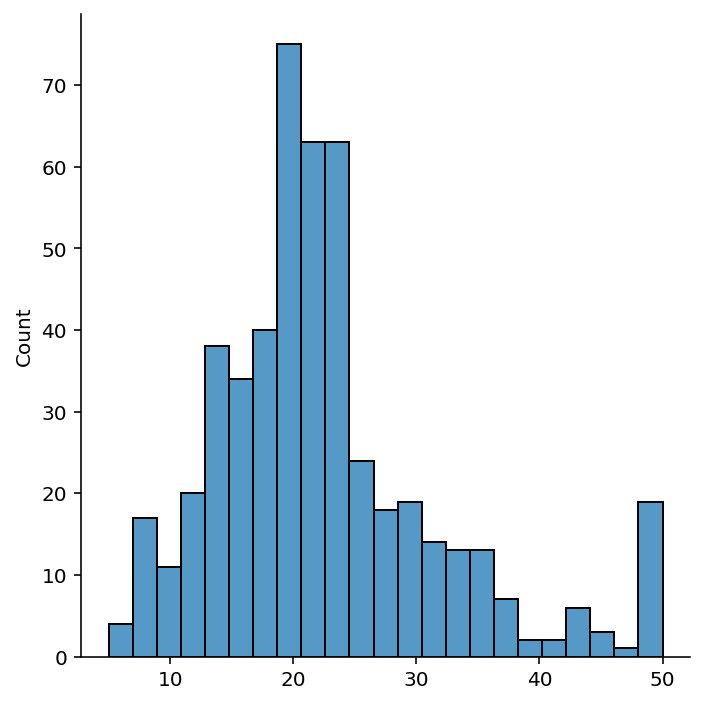

In [9]:
# Let inspect whether the target vartiable follow normal distribution
sns.displot(Boston_target)

The distribution is slightly skewed to the right.

## Random Forest

The random forest is based on applying bagging to decision trees (instead of fitting the various models to the same data, each new model is fitted to a bootstrap resample), with one important extension: in addition to sampling the records, the algorithm also samples the variables.

In [10]:
x = Boston # Features
y = Boston_target  # Target

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [12]:
# hyper-parameter space:

#These parameters need to be set before fitting a model, they are not optimized as part of the training process. 
#The hyperparameters for random forest are critical, especially to avoid overfitting. 

param_grid_RF = {
    'n_estimators' : [10,20,50,100,200,500,1000],
    'max_features' : [0.6,0.8,"auto","sqrt"],
    'max_depth' : [2,4,5,6]
}

# build random forest model
rf_model = RandomForestRegressor(random_state=42,n_jobs=-1)
# gridsearch for the best hyper-parameter
gs_rf = GridSearchCV(rf_model, param_grid=param_grid_RF, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# fit dataset
gs_rf.fit(x_train, y_train)

regressor = RandomForestRegressor(random_state=42, n_estimators=gs_rf.best_params_['n_estimators'], max_depth=gs_rf.best_params_['max_depth'], 
                                  max_features= gs_rf.best_params_['max_features']) 
regressor.fit(x_train, y_train)
    
y_pred = regressor.predict(x_test)
    
prediction_dict = pd.DataFrame(columns = ['real','predicted'])
prediction_dict.real = y_test
prediction_dict.predicted = y_pred

# RMSE (Root Mean Square Error)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
r2 = r2_score(y_test, y_pred)
print("\nRMSE:\n",rmse)
print("\nr2:\n",r2)
       
#feature importance
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                         index=x_train.columns,columns=['importance']).sort_values('importance',ascending = False)   


RMSE:
 2.975

r2:
 0.8793197812500843


#### Mean accuracy of 88%

In [13]:
prediction_dict

,real,predicted
0,23.6,23.169517
1,32.4,30.909518
2,13.6,16.320642
3,22.8,23.240991
4,16.1,16.826339
...,...,...
97,17.9,12.928840
98,9.6,12.821176
99,17.2,13.994026
100,22.5,21.035881


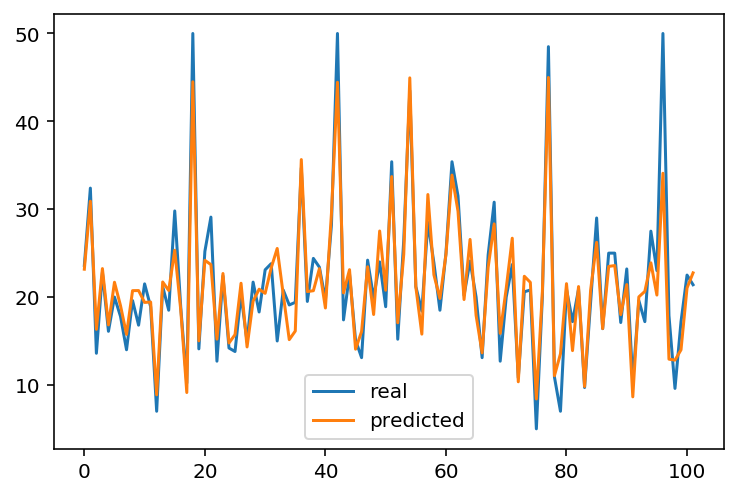

In [14]:
prediction_dict.plot()

### Variable Importance

Random forest algorithm is powerfull when building predictive models for data with many features and records. It has the ability to automatically determine which predictors are important and discover complex relationships between predictors. Since we are using a regressor, we are talking about variance reduction 

To get the feature importances from the Random Forest model use the feature_importances_ argument. 
The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
It is also known as the Gini importance. However, impurity-based feature importances can be misleading for high cardinality features (many unique values). Also, in the case of correlated features it can select one of the features and neglect the importance of the second one (which can lead to wrong conclusions). An alternative can be to use the permutation-based importance. See [Permutation Importance Method](https://scikit-learn.org/stable/modules/permutation_importance.html).

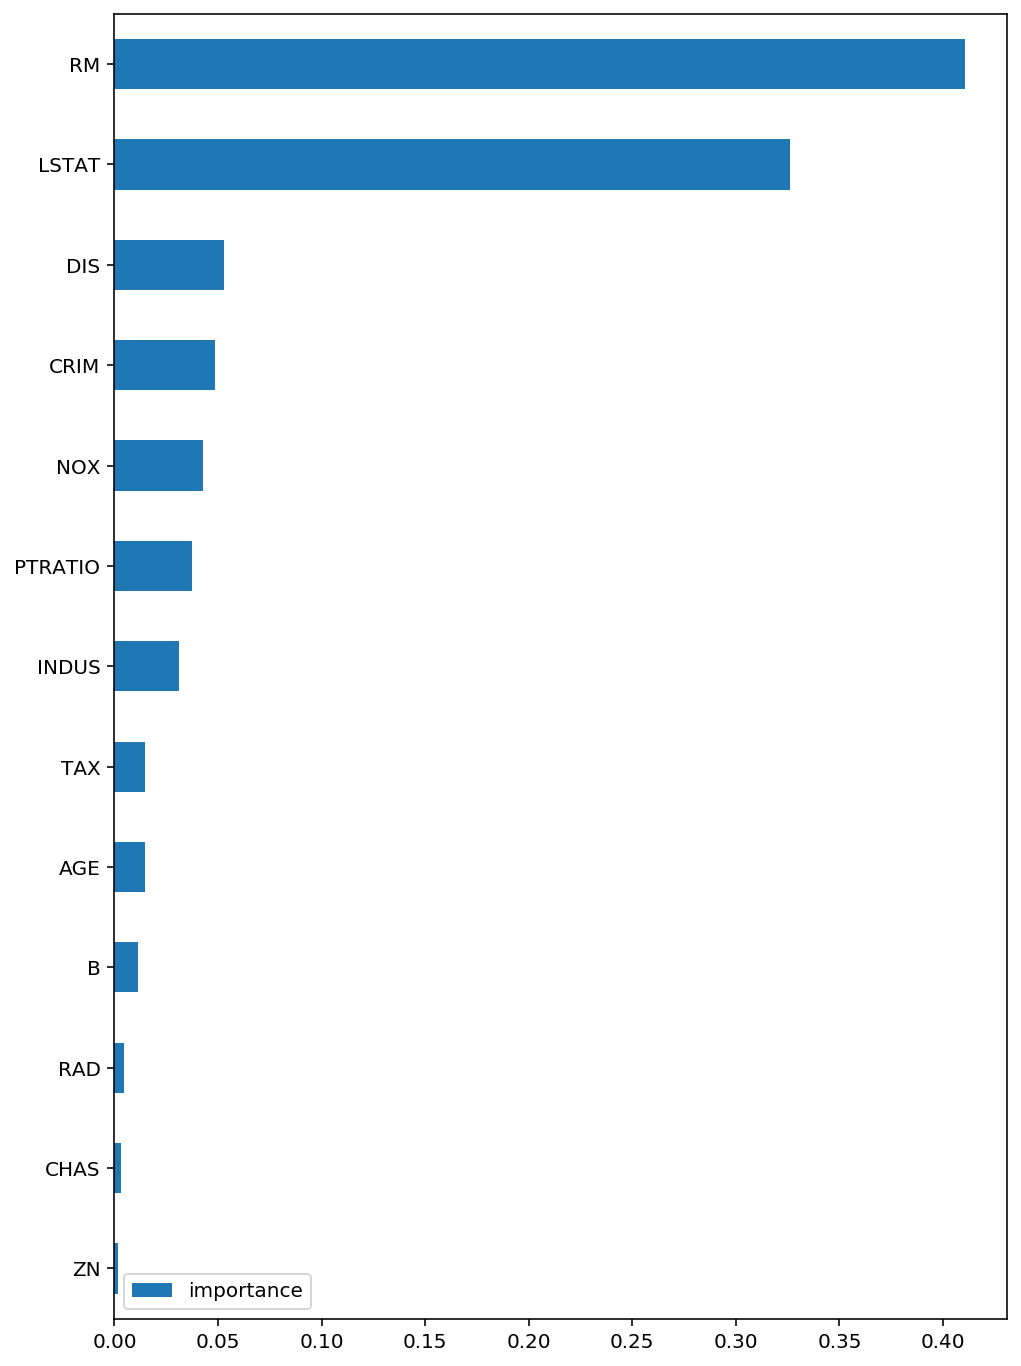

In [15]:
df = feature_importances.iloc[::-1]
df.plot.barh(stacked=True, figsize=(8,12));

The RM, average number of rooms per dwelling, seems to be the variable with higher importance for the model. This makes sense since in general bigger room leads to a higher house cost. Let's plot these 2 variables:

In [16]:
Boston['MEDV'] = Boston_target

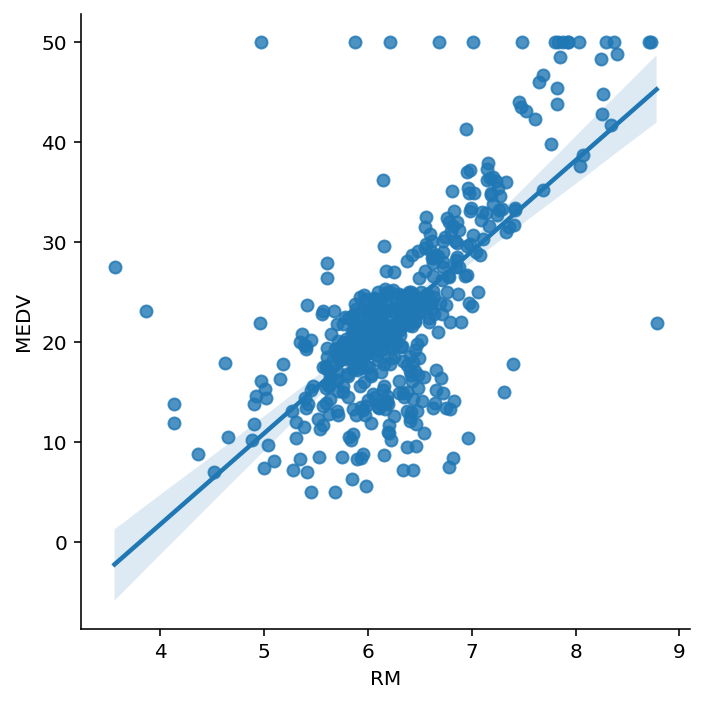

In [17]:
sns.lmplot(data=Boston, x='RM', y='MEDV')

However, we can see that some houses have MEDV of 50.00 regardless of room size. so, other factors might play a role, like '% lower status of the population' that comes next in the feature importance. 

## Sources

1. <a href="https://www.oreilly.com/library/view/practical-statistics-for/9781491952955/" target="_blank">Practical Statistics for Data Scientists</a>

2. <a href="https://towardsdatascience.com/the-3-ways-to-compute-feature-importance-in-the-random-forest-96c86b49e6d4" target="_blank">The 3 Ways To Compute Feature Importance in the Random Forest</a>